In [ ]:
#pip install tensorflow==1.15
#Install stable-baselines as described in the documentation

import gym
import gym_pcgrl
from gym_pcgrl import wrappers

from utils import get_exp_name, max_exp_idx, load_model, make_vec_envs
from stable_baselines import PPO2
from stable_baselines.common.vec_env import SubprocVecEnv, DummyVecEnv

import tensorflow as tf
import numpy as np

import model
model.FullyConvPolicy = model.FullyConvPolicySmallMap
# from model import FullyConvPolicySmallMap as FullyConvPolicy

model = PPO2.load("my_models/binary/wide/model_1.pkl")
# model.save("tests/zelda_turtle_onlymap_3_test", cloudpickle=False)
# model = PPO2.load("runs/binary_narrow_no_visits_no_heatmap_no_changes_1_log/latest_model.pkl")

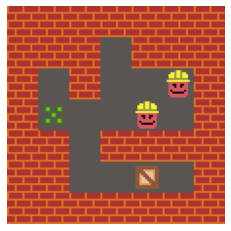

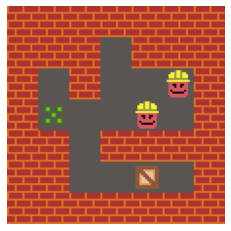

[{'player': 2, 'crate': 1, 'target': 1, 'regions': 1, 'dist-win': 250, 'sol-length': 0, 'iterations': 250, 'changes': 3, 'max_iterations': 250, 'max_changes': 10, 'terminal_observation': array([[[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]],

       [[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.]],

       [[0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]],

       [[0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.]]])}]


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

def show_state(env, l, c, r, step=0, name="", info=""):
    fig = plt.figure(10)
    plt.clf()
    
#     plt.title("{} | Step: {} Path: {} Changes: {} Regions: {}".format(name, step, l[-1], c[-1], r[-1]))
    
#     ax1 = fig.add_subplot(1,4,1)
    ax1 = plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')
    
#     ax2 = fig.add_subplot(1,4,2)
#     ax2 = plt.plot(l)
    
#     ax3 = fig.add_subplot(1,4,3)
#     ax3 = plt.plot(c)
    
#     ax4 = fig.add_subplot(1,4,4)
#     ax4 = plt.plot(r)
    
    
#     fig.set_figwidth(15)
#     plt.tight_layout()
    
    display.clear_output(wait=True)
    display.display(plt.gcf())

def get_env_fun(p_name, r_name, crop_size, ch_perc):
    def get_env():
        if r_name != "wide":
            env = wrappers.CroppedImagePCGRLWrapper("{}-{}-v0".format(p_name, r_name), crop_size, random_tile=False, change_percentage=min(0.2, ch_perc))
            env.pcgrl_env.adjust_param(change_percentage=ch_perc)
        else:
            env = wrappers.ActionMapImagePCGRLWrapper("{}-{}-v0".format(p_name, r_name), change_percentage=min(0.2, ch_perc))
            env.pcgrl_env.adjust_param(change_percentage=ch_perc)
        return env
    return get_env

env = DummyVecEnv([get_env_fun('sokoban', 'wide', 28, 0.4)])
# model = PPO2(CustomPolicy, env, verbose=1, tensorboard_log="./runs")

# Enjoy trained agent
path_length = []
changes = []
regions = []
obs = env.reset()
obs = env.reset()
fixed_array = None
if fixed_array is not None:
    env.get_attr('pcgrl_env')[0]._rep._map = np.array(fixed_array)
    env.get_attr('pcgrl_env')[0]._rep._old_map = np.array(fixed_array)
frames = [env.get_attr('pcgrl_env')[0]._rep.get_observation()['map']]
dones = False
i = 0
while not dones:
    i += 1
    action, _states = model.predict(obs)
    #action = np.array([env.action_space.sample()])
    frames.append(env.get_attr('pcgrl_env')[0]._rep.get_observation()['map'])
    obs, rewards, dones, info = env.step(action)
#     path_length.append(info[0]['path-length'])
#     changes.append(rewards[0])
#     regions.append(info[0]['regions'])
    if dones:
#         print("YAAAAAAAAAAAAAY")
        break
    show_state(env, path_length, changes, regions, i)
plt.show()
print(info)

# Testing Binary Model Results

In [1]:
import gym
import gym_pcgrl
from gym_pcgrl import wrappers

import model
from model import FullyConvPolicySmallMap,FullyConvPolicyBigMap
from utils import get_exp_name, max_exp_idx, load_model, make_vec_envs
from stable_baselines import PPO2
from stable_baselines.common.vec_env import SubprocVecEnv, DummyVecEnv

import tensorflow as tf
import numpy as np
import zlib
import math
import os
from sklearn.decomposition import PCA
from gym_pcgrl.envs.helper import run_dikjstra, _get_certain_tiles, get_tile_locations

binary_lambdas = {
    'pathlength': lambda info: info['path-length'],
    'regions': lambda info: info['regions'],
    'iterations': lambda info: info['iterations'],#/ (1.0 * info['max_iterations']),
    'changes': lambda info: info['changes'],# / (1.0 * info['max_changes']),
    'pathlength_const': lambda info: [0, 1][info['path-length'] >= 48],
    'regions_const': lambda info: [0, 1][info['regions'] == 1],
    'success': lambda info: [0, 1][info['path-length'] >= 48 and info['regions'] == 1]
}
binaryimp_lambdas = {
    'pathlength': lambda info: info['path-length'],
    'path-imp': lambda info: info['path-imp'],
    'regions': lambda info: info['regions'],
    'iterations': lambda info: info['iterations'],#/ (1.0 * info['max_iterations']),
    'changes': lambda info: info['changes'],# / (1.0 * info['max_changes']),
    'pathimp_const': lambda info: [0, 1][info['path-imp'] >= 20],
    'regions_const': lambda info: [0, 1][info['regions'] == 1],
    'success': lambda info: [0, 1][info['path-imp'] >= 20 and info['regions'] == 1]
}
zelda_lambdas = {
    'player': lambda info: info['player'],
    'key': lambda info: info['key'],
    'door': lambda info: info['door'],
    'regions': lambda info: info['regions'],
    'nearestenemy': lambda info: info['nearest-enemy'],
    'pathlength': lambda info: info['path-length'],
    'iterations': lambda info: info['iterations'],
    'changes': lambda info: info['changes'],
    'player_const': lambda info: [0, 1][info['player'] == 1],
    'key_const': lambda info: [0, 1][info['key'] == 1],
    'door_const': lambda info: [0, 1][info['door'] == 1],
    'regions_const': lambda info: [0, 1][info['regions'] == 1],
    'nearestenemy_const': lambda info: [0, 1][info['nearest-enemy'] >= 4],
    'pathlength_const': lambda info: [0, 1][info['path-length'] >= 16],
    'success': lambda info: [0, 1][info['path-length'] >= 16 and info['nearest-enemy'] >= 4]
}
sokoban_lambdas = {
    'player': lambda info: info['player'],
    'crate': lambda info: info['crate'],
    'target': lambda info: info['target'],
    'regions': lambda info: info['regions'],
    'sollength': lambda info: info['sol-length'],
    'iterations': lambda info: info['iterations'],
    'changes': lambda info: info['changes'],
    'player_const': lambda info: [0, 1][info['player'] == 1],
    'ratio_const': lambda info: [0, 1][info['crate'] == info['target'] and info['crate'] > 0],
    'has_sol': lambda info: [0, 1][info['sol-length'] >= 1],
    'success': lambda info: [0, 1][info['sol-length'] >= 18]
}
lambdas = {
    'binary': binary_lambdas,
    'binaryimp': binaryimp_lambdas,
    'zelda': zelda_lambdas,
    'sokoban': sokoban_lambdas
}

def calc_tp_count(lvl, p_size):
    padded_lvl = np.pad(lvl, p_size, constant_values=1)
    pattern_dict = {}
    for (y, x), v in np.ndenumerate(lvl):
        sy, sx = y+p_size-p_size//2, x+p_size-p_size//2
        pattern = str(padded_lvl[sy:sy+p_size,sx:sx+p_size])
        if not (pattern in pattern_dict):
            pattern_dict[pattern] = 0
        pattern_dict[pattern] += 1
    return pattern_dict
        
def calc_tp_kldiv(lvl1, lvl2, p_size=3, epsilon = 1e-6):
    p_dict = calc_tp_count(lvl1, p_size)
    q_dict = calc_tp_count(lvl2, p_size)
    t_patterns = set()
    t_patterns.update(p_dict.keys())
    t_patterns.update(q_dict.keys())
    total_p = sum(p_dict.values())
    total_q = sum(q_dict.values())
    value = 0
    for x in t_patterns:
        p_dash = epsilon/((total_p + epsilon) * (1 + epsilon))
        q_dash = epsilon/((total_q + epsilon) * (1 + epsilon))
        if x in p_dict:
            p_dash = (p_dict[x] + epsilon) / ((total_p + epsilon) * (1 + epsilon))
        if x in q_dict:
            q_dash = (q_dict[x] + epsilon) / ((total_p + epsilon) * (1 + epsilon))
        value += p_dash * math.log(p_dash/q_dash)
    return value

def calc_longest_path(map):
    map_locations = get_tile_locations(map, [0, 1])
    empty_tiles = _get_certain_tiles(map_locations, passable_values)
    final_visited_map = np.zeros((len(map), len(map[0])))
    final_value = 0
    final_loc = (0,0)
    final_map = None
    for (x,y) in empty_tiles:
        if final_visited_map[y][x] > 0:
            continue
        dikjstra_map, visited_map = run_dikjstra(x, y, map, [0])
        final_visited_map += visited_map
        (my,mx) = np.unravel_index(np.argmax(dikjstra_map, axis=None), dikjstra_map.shape)
        dikjstra_map, _ = run_dikjstra(mx, my, map, passable_values)
        (fy, fx) = np.unravel_index(np.argmax(dikjstra_map, axis=None), dikjstra_map.shape)
        max_value = np.max(dikjstra_map)
        if max_value > final_value:
            final_value = max_value
            final_loc = (fx, fy)
            final_map = dikjstra_map
    path = [final_loc]
    current = final_loc
    while final_map[current[1]][current[0]] != 0:
        small = (current[0], current[1])
        for (dx,dy) in [(0,1), (0,-1), (1,0), (-1,0)]:
            new = (current[0] + dx, current[1] + dy)
            if final_map[new[1]][new[0]] == -1 or new[0] < 0 or new[1] < 0 or new[0] >= final_map.shape[1] or new[1] >= final_map.shape[0]:
                continue
            if final_map[new[1]][new[0]] < final_map[small[1]][small[0]]:
                small = new
        path.append(small)
        current = small
    return path

def calc_hamming(lvl1, lvl2):
    return np.clip(abs(lvl1 - lvl2), 0, 1).sum()/(lvl1.shape[0] * lvl1.shape[1])

def calc_compression(lvl1, lvl2):
    c_1 = zlib.compress(lvl1.tobytes(), level=9)
    c_2 = zlib.compress(lvl2.tobytes(), level=9)
    cb = zlib.compress(lvl1.tobytes() + lvl2.tobytes(), level=9)
    return (len(cb) - min(len(c_1), len(c_2))) / max(len(c_1), len(c_2))

div_func = {
    'hamming': lambda lvl1, lvl2: calc_hamming(lvl1, lvl2),
    'tpkldiv': lambda lvl1, lvl2: calc_tp_kldiv(lvl1, lvl2),
    'compression': lambda lvl1, lvl2: calc_compression(lvl1, lvl2)
}

def get_pca_diversity(lvls):
    pca2d = PCA(2)
    temp_reshaped_lvls = np.array(lvls).reshape((len(lvls), -1))
    projected_lvls = pca2d.fit_transform(temp_reshaped_lvls)
    variance = np.var(projected_lvls, axis=0)
    return [np.mean(variance)]

def get_svd_diversity(lvls):
    normalized = []
    for i in range(len(lvls)):
        normalized.append(lvls[i] / np.linalg.norm(lvls[i]))
    temp_reshaped_lvls = np.array(normalized).reshape((len(normalized), -1))
    U, s, V = np.linalg.svd(temp_reshaped_lvls)
    return s

def get_diversity(lvls, d_type="hamming"):
    diversity = []
    for i in range(len(lvls)):
        lvl1 = lvls[i]
        lvl_diversity = []
        for j in range(len(lvls)):
            lvl2 = lvls[j]
            if i != j:
                lvl_diversity.append(div_func[d_type](lvl1, lvl2))
        diversity.append(np.min(lvl_diversity))
    return diversity

def get_env_func(p_name, r_name, ch_perc=0.2, crop_size=28):
    def get_env():
        if r_name != "wide":
            env = wrappers.CroppedImagePCGRLWrapper("{}-{}-v0".format(p_name, r_name), crop_size, add_visits=False, add_heatmap=False, add_changes=False, random_tile=False, change_percentage=min(0.2, ch_perc))
            env.pcgrl_env.adjust_param(change_percentage=ch_perc)
        else:
            env = wrappers.ActionMapImagePCGRLWrapper("{}-{}-v0".format(p_name, r_name), add_visits=False, add_heatmap=False, add_changes=False, change_percentage=min(0.2, ch_perc))
            env.pcgrl_env.adjust_param(change_percentage=ch_perc)
        return env
    return get_env

def sample_data(sample_size, env_func, model, lambdas):
    sample_info = {}
    lvls = []
    for name in lambdas:
        sample_info[name] = []
    env = DummyVecEnv([env_func])
    for i in range(sample_size):
        done = False
        obs = env.reset()
        while not done:
            action, _ = model.predict(obs)
            last_lvl = env.get_attr('pcgrl_env')[0]._rep.get_observation()['map']
            obs, rewards, done, info = env.step(action)
        lvls.append(last_lvl)
        for name in lambdas:
            sample_info[name].append(lambdas[name](info[0]))
    sample_info['hdiversity'] = get_diversity(lvls, "hamming")
#     sample_info['cdiversity'] = get_diversity(lvls, "compression")
#     sample_info['pdiversity'] = get_pca_diversity(lvls)
#     sample_info['sdiversity'] = get_svd_diversity(lvls)
    return sample_info

p_name = "binary"
crop_size = 28
sample_size = 40
rep_names = ["narrow", "turtle", "wide"]
exp_name = '1'
number_of_models = 1
ch_perc_array = np.arange(0, 1.01, 0.1)
result = {}
for i in range(len(rep_names)):
    r_name = rep_names[i]
    if isinstance(exp_name,list):
        e_name = exp_name[i]
    else:
        e_name = exp_name
    for m_index in range(number_of_models):
       # m_name = "{}_{}_{}".format(p_name, r_name, e_name)
        m_name = "model_1"
        print("Loading model {}".format(m_name))
        add_index = ""
        if number_of_models > 1:
            add_index = "_" + str(m_index + 1)
        e_format = 'pkl'
        if not os.path.exists('my_models/binary/{}{}.{}'.format(m_name, add_index, e_format)):
            e_format = 'pkl'
        dir = 'my_models/binary/{}/{}{}.{}'.format(r_name,m_name, add_index, e_format)
        print(dir)
        model = PPO2.load(dir)
        if m_name not in result:
            result[m_name] = {}
        for ch_index in range(len(ch_perc_array)):
            ch_perc = ch_perc_array[ch_index]
            print("Testing {}_{} at change percentage of {}".format(m_name, m_index+1, ch_perc))
            env_func = get_env_func(p_name, r_name, ch_perc, crop_size)
            temp_result = sample_data(sample_size, env_func, model, lambdas[p_name])
            for name in temp_result:
                if not(name in result[m_name]):
                    result[m_name][name] = []
                if number_of_models > 1:
                    if m_index == 0:
                        result[m_name][name].append([np.mean(temp_result[name])])
                    else:
                        result[m_name][name][ch_index].append(np.mean(temp_result[name]))
                else:
                    result[m_name][name].append(np.mean(temp_result[name]))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Loading model model_1
my_models/binary/narrow/model_1.pkl
Loading a model without an environment, this model cannot be trained until it has a valid environment.









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Testing model_1_1 at change percentage of 0.0


c:\Python37\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
c:\Python37\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Testing model_1_1 at change percentage of 0.1
Testing model_1_1 at change percentage of 0.2
Testing model_1_1 at change percentage of 0.30000000000000004
Testing model_1_1 at change percentage of 0.4
Testing model_1_1 at change percentage of 0.5
Testing model_1_1 at change percentage of 0.6000000000000001
Testing model_1_1 at change percentage of 0.7000000000000001
Testing model_1_1 at change percentage of 0.8
Testing model_1_1 at change percentage of 0.9
Testing model_1_1 at change percentage of 1.0
Loading model model_1
my_models/binary/turtle/model_1.pkl
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Testing model_1_1 at change percentage of 0.0


c:\Python37\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
c:\Python37\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Testing model_1_1 at change percentage of 0.1
Testing model_1_1 at change percentage of 0.2
Testing model_1_1 at change percentage of 0.30000000000000004
Testing model_1_1 at change percentage of 0.4
Testing model_1_1 at change percentage of 0.5
Testing model_1_1 at change percentage of 0.6000000000000001
Testing model_1_1 at change percentage of 0.7000000000000001
Testing model_1_1 at change percentage of 0.8
Testing model_1_1 at change percentage of 0.9
Testing model_1_1 at change percentage of 1.0
Loading model model_1
my_models/binary/wide/model_1.pkl
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Testing model_1_1 at change percentage of 0.0


c:\Python37\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
c:\Python37\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Testing model_1_1 at change percentage of 0.1
Testing model_1_1 at change percentage of 0.2
Testing model_1_1 at change percentage of 0.30000000000000004
Testing model_1_1 at change percentage of 0.4
Testing model_1_1 at change percentage of 0.5
Testing model_1_1 at change percentage of 0.6000000000000001
Testing model_1_1 at change percentage of 0.7000000000000001
Testing model_1_1 at change percentage of 0.8
Testing model_1_1 at change percentage of 0.9
Testing model_1_1 at change percentage of 1.0


# Overcoming the serialization issue

In [5]:
import gym
import gym_pcgrl
from gym_pcgrl import wrappers

import model
from model import FullyConvPolicySmallMap,FullyConvPolicyBigMap
from utils import get_exp_name, max_exp_idx, load_model, make_vec_envs
from stable_baselines import PPO2
from stable_baselines.common.vec_env import SubprocVecEnv, DummyVecEnv

import tensorflow as tf
import numpy as np
import zlib
import math
import os
# from sklearn.decomposition import PCA
from gym_pcgrl.envs.helper import run_dikjstra, _get_certain_tiles, get_tile_locations

binary_lambdas = {
    'pathlength': lambda info: info['path-length'],
    'regions': lambda info: info['regions'],
    'iterations': lambda info: info['iterations'],#/ (1.0 * info['max_iterations']),
    'changes': lambda info: info['changes'],# / (1.0 * info['max_changes']),
    'pathlength_const': lambda info: [0, 1][info['path-length'] >= 48],
    'regions_const': lambda info: [0, 1][info['regions'] == 1],
    'success': lambda info: [0, 1][info['path-length'] >= 48 and info['regions'] == 1]
}
binaryimp_lambdas = {
    'pathlength': lambda info: info['path-length'],
    'path-imp': lambda info: info['path-imp'],
    'regions': lambda info: info['regions'],
    'iterations': lambda info: info['iterations'],#/ (1.0 * info['max_iterations']),
    'changes': lambda info: info['changes'],# / (1.0 * info['max_changes']),
    'pathimp_const': lambda info: [0, 1][info['path-imp'] >= 20],
    'regions_const': lambda info: [0, 1][info['regions'] == 1],
    'success': lambda info: [0, 1][info['path-imp'] >= 20 and info['regions'] == 1]
}
zelda_lambdas = {
    'player': lambda info: info['player'],
    'key': lambda info: info['key'],
    'door': lambda info: info['door'],
    'regions': lambda info: info['regions'],
    'nearestenemy': lambda info: info['nearest-enemy'],
    'pathlength': lambda info: info['path-length'],
    'iterations': lambda info: info['iterations'],
    'changes': lambda info: info['changes'],
    'player_const': lambda info: [0, 1][info['player'] == 1],
    'key_const': lambda info: [0, 1][info['key'] == 1],
    'door_const': lambda info: [0, 1][info['door'] == 1],
    'regions_const': lambda info: [0, 1][info['regions'] == 1],
    'nearestenemy_const': lambda info: [0, 1][info['nearest-enemy'] >= 4],
    'pathlength_const': lambda info: [0, 1][info['path-length'] >= 16],
    'has_sol': lambda info: [0, 1][info['path-length'] >= 1 and info['nearest-enemy'] >= 4],
    'success': lambda info: [0, 1][info['path-length'] >= 16 and info['nearest-enemy'] >= 4]
}
sokoban_lambdas = {
    'player': lambda info: info['player'],
    'crate': lambda info: info['crate'],
    'target': lambda info: info['target'],
    'regions': lambda info: info['regions'],
    'sollength': lambda info: info['sol-length'],
    'iterations': lambda info: info['iterations'],
    'changes': lambda info: info['changes'],
    'player_const': lambda info: [0, 1][info['player'] == 1],
    'ratio_const': lambda info: [0, 1][info['crate'] == info['target'] and info['crate'] > 0],
    'has_sol': lambda info: [0, 1][info['sol-length'] >= 1],
    'success': lambda info: [0, 1][info['sol-length'] >= 18]
}
lambdas = {
    'binary': binaryimp_lambdas,
    'binaryimp': binaryimp_lambdas,
    'zelda': zelda_lambdas,
    'sokoban': sokoban_lambdas
}

def calc_tp_count(lvl, p_size):
    padded_lvl = np.pad(lvl, p_size, constant_values=1)
    pattern_dict = {}
    for (y, x), v in np.ndenumerate(lvl):
        sy, sx = y+p_size-p_size//2, x+p_size-p_size//2
        pattern = str(padded_lvl[sy:sy+p_size,sx:sx+p_size])
        if not (pattern in pattern_dict):
            pattern_dict[pattern] = 0
        pattern_dict[pattern] += 1
    return pattern_dict
        
def calc_tp_kldiv(lvl1, lvl2, p_size=3, epsilon = 1e-6):
    p_dict = calc_tp_count(lvl1, p_size)
    q_dict = calc_tp_count(lvl2, p_size)
    t_patterns = set()
    t_patterns.update(p_dict.keys())
    t_patterns.update(q_dict.keys())
    total_p = sum(p_dict.values())
    total_q = sum(q_dict.values())
    value = 0
    for x in t_patterns:
        p_dash = epsilon/((total_p + epsilon) * (1 + epsilon))
        q_dash = epsilon/((total_q + epsilon) * (1 + epsilon))
        if x in p_dict:
            p_dash = (p_dict[x] + epsilon) / ((total_p + epsilon) * (1 + epsilon))
        if x in q_dict:
            q_dash = (q_dict[x] + epsilon) / ((total_p + epsilon) * (1 + epsilon))
        value += p_dash * math.log(p_dash/q_dash)
    return value

def calc_longest_path(map):
    map_locations = get_tile_locations(map, [0, 1])
    empty_tiles = _get_certain_tiles(map_locations, passable_values)
    final_visited_map = np.zeros((len(map), len(map[0])))
    final_value = 0
    final_loc = (0,0)
    final_map = None
    for (x,y) in empty_tiles:
        if final_visited_map[y][x] > 0:
            continue
        dikjstra_map, visited_map = run_dikjstra(x, y, map, [0])
        final_visited_map += visited_map
        (my,mx) = np.unravel_index(np.argmax(dikjstra_map, axis=None), dikjstra_map.shape)
        dikjstra_map, _ = run_dikjstra(mx, my, map, passable_values)
        (fy, fx) = np.unravel_index(np.argmax(dikjstra_map, axis=None), dikjstra_map.shape)
        max_value = np.max(dikjstra_map)
        if max_value > final_value:
            final_value = max_value
            final_loc = (fx, fy)
            final_map = dikjstra_map
    path = [final_loc]
    current = final_loc
    while final_map[current[1]][current[0]] != 0:
        small = (current[0], current[1])
        for (dx,dy) in [(0,1), (0,-1), (1,0), (-1,0)]:
            new = (current[0] + dx, current[1] + dy)
            if final_map[new[1]][new[0]] == -1 or new[0] < 0 or new[1] < 0 or new[0] >= final_map.shape[1] or new[1] >= final_map.shape[0]:
                continue
            if final_map[new[1]][new[0]] < final_map[small[1]][small[0]]:
                small = new
        path.append(small)
        current = small
    return path

def calc_hamming(lvl1, lvl2):
    return np.clip(abs(lvl1 - lvl2), 0, 1).sum()/(lvl1.shape[0] * lvl1.shape[1])

def calc_compression(lvl1, lvl2):
    c_1 = zlib.compress(lvl1.tobytes(), level=9)
    c_2 = zlib.compress(lvl2.tobytes(), level=9)
    cb = zlib.compress(lvl1.tobytes() + lvl2.tobytes(), level=9)
    return (len(cb) - min(len(c_1), len(c_2))) / max(len(c_1), len(c_2))

div_func = {
    'hamming': lambda lvl1, lvl2: calc_hamming(lvl1, lvl2),
    'tpkldiv': lambda lvl1, lvl2: calc_tp_kldiv(lvl1, lvl2),
    'compression': lambda lvl1, lvl2: calc_compression(lvl1, lvl2)
}

def get_pca_diversity(lvls):
    pca2d = PCA(2)
    temp_reshaped_lvls = np.array(lvls).reshape((len(lvls), -1))
    projected_lvls = pca2d.fit_transform(temp_reshaped_lvls)
    variance = np.var(projected_lvls, axis=0)
    return [np.mean(variance)]

def get_svd_diversity(lvls):
    normalized = []
    for i in range(len(lvls)):
        normalized.append(lvls[i] / np.linalg.norm(lvls[i]))
    temp_reshaped_lvls = np.array(normalized).reshape((len(normalized), -1))
    U, s, V = np.linalg.svd(temp_reshaped_lvls)
    return s

def get_diversity(lvls, d_type="hamming"):
    diversity = []
    for i in range(len(lvls)):
        lvl1 = lvls[i]
        lvl_diversity = []
        for j in range(len(lvls)):
            lvl2 = lvls[j]
            if i != j:
                lvl_diversity.append(div_func[d_type](lvl1, lvl2))
        diversity.append(np.min(lvl_diversity))
    return diversity

def get_env_func(p_name, r_name, ch_perc=0.2, crop_size=28):
    def get_env():
        if r_name != "wide":
            env = wrappers.CroppedImagePCGRLWrapper("{}-{}-v0".format(p_name, r_name), crop_size, add_visits=False, add_heatmap=False, add_changes=False, random_tile=False, change_percentage=min(0.2, ch_perc))
            env.pcgrl_env.adjust_param(change_percentage=ch_perc)
        else:
            env = wrappers.ActionMapImagePCGRLWrapper("{}-{}-v0".format(p_name, r_name), add_visits=False, add_heatmap=False, add_changes=False, change_percentage=min(0.2, ch_perc))
            env.pcgrl_env.adjust_param(change_percentage=ch_perc)
        return env
    return get_env

def sample_data(sample_size, env_func, model, lambdas):
    sample_info = {}
    lvls = []
    for name in lambdas:
        sample_info[name] = []
    env = DummyVecEnv([env_func])
    for i in range(sample_size):
        done = False
        obs = env.reset()
        while not done:
            if model is None:
                action = [env.action_space.sample()]
            else:
                action, _ = model.predict(obs)
            last_lvl = env.get_attr('pcgrl_env')[0]._rep.get_observation()['map']
            obs, rewards, done, info = env.step(action)
        lvls.append(last_lvl)
        for name in lambdas:
            sample_info[name].append(lambdas[name](info[0]))
    sample_info['hdiversity'] = get_diversity(lvls, "hamming")
#     sample_info['cdiversity'] = get_diversity(lvls, "compression")
#     sample_info['pdiversity'] = get_pca_diversity(lvls)
#     sample_info['sdiversity'] = get_svd_diversity(lvls)
    return sample_info

def get_result_dict(ch_perc_array, lambdafuncs):
    result = {}
    for name in lambdafuncs:
        result[name] = []
        for _ in ch_perc_array:
            result[name].append([])
    result['hdiversity'] = []        
    for _ in ch_perc_array:
        result['hdiversity'].append([])
    return result

def get_change_percentage_data(model, p_name, r_name, crop_size, sample_size, ch_perc_array, lambdafuncs, result):
    for ch_index in range(len(ch_perc_array)):
        ch_perc = ch_perc_array[ch_index]
        print("Testing {}_{} at change percentage of {}".format(p_name, r_name, ch_perc))
        env_func = get_env_func(p_name, r_name, ch_perc, crop_size)
        temp_result = sample_data(sample_size, env_func, model, lambdafuncs)
        for name in temp_result:
            result[name][ch_index].append(np.mean(temp_result[name]))

In [6]:
p_name = "binary"
ch_perc_array = np.arange(0, 1.01, 0.1)
lambdafuncs = lambdas[p_name]

result = {}
result['{}_narrow'.format(p_name)] = get_result_dict(ch_perc_array, lambdafuncs)
result['{}_turtle'.format(p_name)] = get_result_dict(ch_perc_array, lambdafuncs)
result['{}_wide'.format(p_name)] = get_result_dict(ch_perc_array, lambdafuncs)

In [7]:
import json

with open('{}_results.json'.format(p_name)) as fp:
    result = json.load(fp)
    
print(result)
#result['{}_random'.format(p_name)] = get_result_dict(ch_perc_array, lambdafuncs)
result['{}_turtle random'.format(p_name)] = get_result_dict(ch_perc_array, lambdafuncs)
# result['{}_wide random'.format(p_name)] = get_result_dict(ch_perc_array, lambdafuncs)

FileNotFoundError: [Errno 2] No such file or directory: 'binary_results.json'

In [9]:
crop_size = 28
sample_size = 40
r_names = ["narrow", "turtle", "wide"]
for i in range(len(r_names)):
    r_name = r_names[i]
    print("Testing {}_{}".format(p_name, r_name))
    model = None
    model = PPO2.load('my_models/{}/{}/model_1.pkl'.format(p_name, r_name))
    res_name = r_name
    if model is None:
        res_name = "random"
    get_change_percentage_data(model, p_name, r_name, crop_size, sample_size, ch_perc_array, lambdafuncs, result['{}_{}'.format(p_name, res_name)])


Testing binary_narrow
Loading a model without an environment, this model cannot be trained until it has a valid environment.


Testing binary_narrow at change percentage of 0.0


c:\Python37\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
c:\Python37\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Testing binary_narrow at change percentage of 0.1
Testing binary_narrow at change percentage of 0.2
Testing binary_narrow at change percentage of 0.30000000000000004
Testing binary_narrow at change percentage of 0.4
Testing binary_narrow at change percentage of 0.5
Testing binary_narrow at change percentage of 0.6000000000000001
Testing binary_narrow at change percentage of 0.7000000000000001
Testing binary_narrow at change percentage of 0.8
Testing binary_narrow at change percentage of 0.9
Testing binary_narrow at change percentage of 1.0
Testing binary_turtle
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Testing binary_turtle at change percentage of 0.0


c:\Python37\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
c:\Python37\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Testing binary_turtle at change percentage of 0.1
Testing binary_turtle at change percentage of 0.2
Testing binary_turtle at change percentage of 0.30000000000000004
Testing binary_turtle at change percentage of 0.4
Testing binary_turtle at change percentage of 0.5
Testing binary_turtle at change percentage of 0.6000000000000001
Testing binary_turtle at change percentage of 0.7000000000000001
Testing binary_turtle at change percentage of 0.8
Testing binary_turtle at change percentage of 0.9
Testing binary_turtle at change percentage of 1.0
Testing binary_wide
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Testing binary_wide at change percentage of 0.0


c:\Python37\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
c:\Python37\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Testing binary_wide at change percentage of 0.1
Testing binary_wide at change percentage of 0.2
Testing binary_wide at change percentage of 0.30000000000000004
Testing binary_wide at change percentage of 0.4
Testing binary_wide at change percentage of 0.5
Testing binary_wide at change percentage of 0.6000000000000001
Testing binary_wide at change percentage of 0.7000000000000001
Testing binary_wide at change percentage of 0.8
Testing binary_wide at change percentage of 0.9
Testing binary_wide at change percentage of 1.0


In [10]:
import json
print(p_name)
with open('{}_results.json'.format(p_name), 'w') as fp:
    json.dump(result, fp)
print(result)

binary
{'binary_narrow': {'pathlength': [[17.65], [26.05], [38.275], [36.5], [41.35], [42.775], [39.325], [44.0], [39.925], [41.275], [41.175]], 'path-imp': [[0.55], [12.375], [21.075], [23.75], [24.5], [26.375], [25.45], [26.775], [26.925], [26.725], [26.425]], 'regions': [[12.8], [4.525], [1.375], [1.375], [1.125], [1.125], [1.0], [1.0], [1.05], [1.025], [1.05]], 'iterations': [[8.625], [160.225], [460.975], [887.05], [1154.45], [2071.85], [1152.3], [916.125], [2679.9], [1963.425], [2969.6]], 'changes': [[1.0], [19.0], [33.0], [39.625], [42.2], [46.25], [46.425], [40.275], [53.225], [51.325], [47.25]], 'pathimp_const': [[0.0], [0.2], [0.65], [0.825], [0.95], [1.0], [0.975], [1.0], [1.0], [0.975], [0.975]], 'regions_const': [[0.125], [0.125], [0.725], [0.775], [0.9], [0.875], [1.0], [1.0], [0.95], [0.975], [0.95]], 'success': [[0.0], [0.0], [0.6], [0.75], [0.85], [0.875], [0.975], [1.0], [0.95], [0.975], [0.95]], 'hdiversity': [[0.2746173469387755], [0.3128826530612245], [0.3566326530

# Single Model Graphs

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

def get_data(results, name):
    output = {}
    for n in results:
        output[n] = results[n][name]
    return output

def plt_dict(p_dict, y_title, file_name):
    plt.figure()
    names = []
    for name in p_dict:
        plt.plot(np.array(ch_perc_array),p_dict[name])
        names.append(name)
    plt.legend(names)
    plt.xlim(0.0,1.0)
    plt.xticks(np.array(ch_perc_array), rotation=90)
    plt.xlabel('change percentage')
    plt.ylabel(y_title)
    plt.savefig('graphs/' + file_name + ".pdf")
    for n in lambdas[p_name]:
        plt_dict(get_data(result, n), n, '{}_{}_{}'.format(p_name, exp_name, n))
    plt_dict(get_data(result, 'hdiversity'), 'hamming diversity', '{}_{}_{}'.format(p_name,exp_name,'hammingdiversity'))
    plt_dict(get_data(result, 'cdiversity'), 'compression diversity', '{}_{}_{}'.format(p_name,exp_name,'compressiondiversity'))
    plt_dict(get_data(result, 'pdiversity'), 'pca diversity', '{}_{}_{}'.format(p_name,exp_name,'pcadiversity'))
    plt_dict(get_data(result, 'sdiversity'), 'svd diversity', '{}_{}_{}'.format(p_name,exp_name,'svddiversity'))


# Paper Graphs with multi models

{'binary_narrow': {'pathlength': [[17.65], [26.05], [38.275], [36.5], [41.35], [42.775], [39.325], [44.0], [39.925], [41.275], [41.175]], 'path-imp': [[0.55], [12.375], [21.075], [23.75], [24.5], [26.375], [25.45], [26.775], [26.925], [26.725], [26.425]], 'regions': [[12.8], [4.525], [1.375], [1.375], [1.125], [1.125], [1.0], [1.0], [1.05], [1.025], [1.05]], 'iterations': [[8.625], [160.225], [460.975], [887.05], [1154.45], [2071.85], [1152.3], [916.125], [2679.9], [1963.425], [2969.6]], 'changes': [[1.0], [19.0], [33.0], [39.625], [42.2], [46.25], [46.425], [40.275], [53.225], [51.325], [47.25]], 'pathimp_const': [[0.0], [0.2], [0.65], [0.825], [0.95], [1.0], [0.975], [1.0], [1.0], [0.975], [0.975]], 'regions_const': [[0.125], [0.125], [0.725], [0.775], [0.9], [0.875], [1.0], [1.0], [0.95], [0.975], [0.95]], 'success': [[0.0], [0.0], [0.6], [0.75], [0.85], [0.875], [0.975], [1.0], [0.95], [0.975], [0.95]], 'hdiversity': [[0.2746173469387755], [0.3128826530612245], [0.3566326530612245]

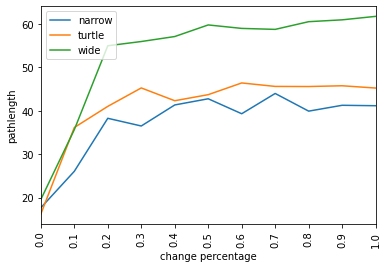

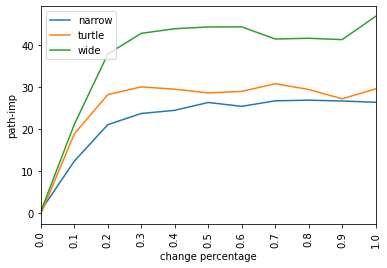

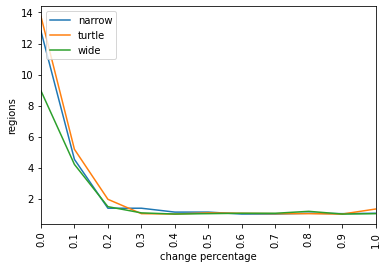

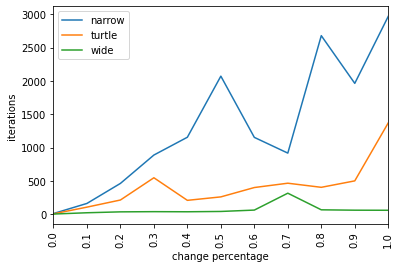

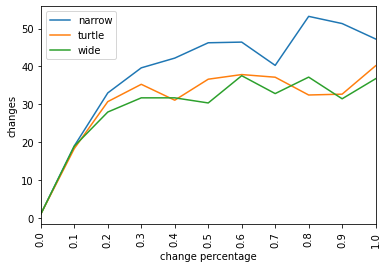

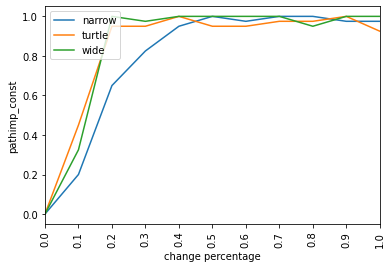

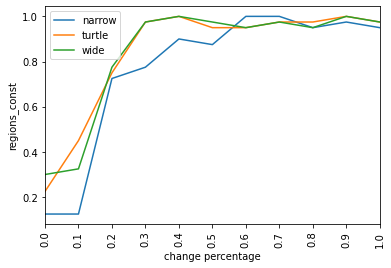

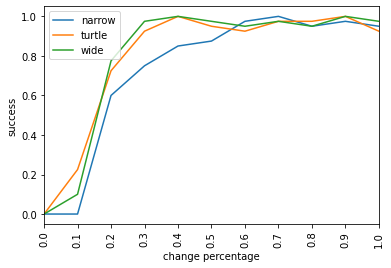

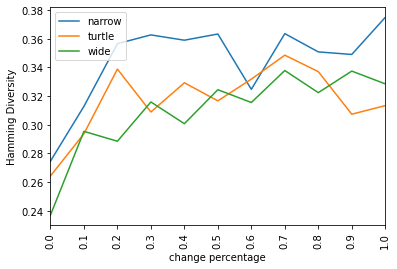

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import os
def get_data(results, name):
    output = {}
    print(results, name)
    for n in results:
        output[n] = results[n][name]
    return output

def getMeanSTD(inputarray):
    mean = []
    std = []
    for i in range(len(inputarray)):
        mean.append(np.mean(inputarray[i]))
        std.append(np.std(inputarray[i]))
    return np.array(mean), np.array(std)

def plt_dict(p_dict, y_title, file_name):
    plt.figure()
    names = []
    for t_name in ["narrow", "turtle", "wide"]:
        name = p_name + "_" + t_name
        print(name, p_dict)
        mean, std = getMeanSTD(p_dict[name])
        plt.plot(np.array(ch_perc_array), mean)
        plt.fill_between(np.array(ch_perc_array), mean - std, mean + std, alpha=0.2)
        names.append(name.split("_")[1])
    plt.legend(names, loc='upper left')
    plt.xlim(0.0,1.0)
    plt.xticks(np.array(ch_perc_array), rotation=90)
    plt.xlabel('change percentage')
    plt.ylabel(y_title)
    if not os.path.exists('graphs'):
        os.makedirs('graphs')

    plt.savefig('graphs/' + file_name + ".pdf", bbox_inches='tight')

for n in lambdas[p_name]:
    if n == "has_sol":
        continue
    plt_dict(get_data(result, n), n, '{}_{}'.format(p_name, n))
plt_dict(get_data(result, 'hdiversity'), 'Hamming Diversity', '{}_{}'.format(p_name,'hammingdiversity'))
# plt_dict(get_data(result, 'cdiversity'), 'compression diversity', '{}_{}_{}'.format(p_name,exp_name,'compressiondiversity'))
# plt_dict(get_data(result, 'pdiversity'), 'pca diversity', '{}_{}_{}'.format(p_name,exp_name,'pcadiversity'))
# plt_dict(get_data(result, 'sdiversity'), 'svd diversity', '{}_{}_{}'.format(p_name,exp_name,'svddiversity'))

# Testing solid probability with 0.5 change rate

In [17]:
import gym
import gym_pcgrl
from gym_pcgrl import wrappers

from stable_baselines.common.policies import MlpPolicy, CnnPolicy, FeedForwardPolicy
from stable_baselines.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines.a2c.utils import conv, linear, conv_to_fc
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines import PPO2

import tensorflow as tf
import numpy as np

import pdb

p_name = "sokoban"
rep_names = ["narrow", "turtle"]
exp_names = ["noaction_heatmap_changes_100M", "heatmap_changes_100M"]

def get_env_func(p_name, r_name, solid_perc=0.2):
    def get_env():
        env = wrappers.CroppedImagePCGRLWrapper("{}-{}-v0".format(p_name, r_name), 28, random_tile=False, change_percentage=0.4, probs={"empty":1-solid_perc, "solid":solid_perc})
        return env
    return get_env

def get_action(env, model, action_type=True):
    action = None
    if action_type == 0:
        action, _ = model.predict(obs)
    elif action_type == 1:
        action_prob = model.action_probability(obs)[0]
        action = np.random.choice(a=list(range(len(action_prob))), size=1, p=action_prob)
    else:
        action = np.array([env.action_space.sample()])
    return action

pathlength_perc = {}
pathlength={}
regions_perc = {}
regions={}
both_perc = {}
for i in range(len(exp_names)):
    r_name = rep_names[i]
    e_name = exp_names[i]
    m_name = "{}_{}_{}".format(p_name, r_name, e_name)
    pathlength_perc[m_name] = []
    pathlength[m_name] = []
    regions_perc[m_name] = []
    regions[m_name] = []
    both_perc[m_name] = []
    model = PPO2.load(m_name)
    for solid_perc in np.arange(0.0, 1.01, 0.05):
        print("Testing {} at solid percentage of {}".format(m_name,solid_perc))
        temp_path = []
        temp_length = []
        temp_regions = []
        temp_number = []
        temp_both = []
        for i in range(20):
            env = DummyVecEnv([get_env_func(p_name, r_name, ch_perc)])
            done = False
            obs = env.reset()
            while not done:
                action = get_action(env, model, 0)
                obs, rewards, done, info = env.step(action)
            temp_path.append([0,1][info[0]['path-length']>=48])
            temp_length.append(info[0]['path-length'])
            temp_regions.append([0,1][info[0]['regions']==1])
            temp_number.append(info[0]['regions'])
            temp_both.append([0,1][temp_path[-1] == 1 and temp_regions[-1] == 1])
        pathlength_perc[m_name].append(np.mean(temp_path))
        pathlength[m_name].append(np.mean(temp_length))
        regions_perc[m_name].append(np.mean(temp_regions))
        regions[m_name].append(np.mean(temp_number))
        both_perc[m_name].append(np.mean(temp_both))

ValueError: Error: the file binary_narrow_noaction_heatmap_changes_100M could not be found

ValueError: x and y must have same first dimension, but have shapes (21,) and (0,)

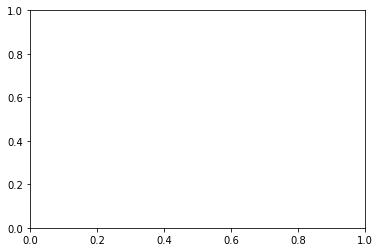

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

plt.figure()
names = []
for name in regions_perc:
    plt.plot(np.array(np.arange(0.0,1.01,0.05)),regions_perc[name])
    names.append(name)
plt.legend(names)
plt.xlim(0.0,1.0)
plt.xticks(np.array(np.arange(0.0,1.01,0.05)), rotation=90)
plt.title('Region == 1')
plt.savefig('const_regions.pdf')

plt.figure()
names = []
for name in pathlength_perc:
    plt.plot(np.array(np.arange(0.0,1.01,0.05)),pathlength_perc[name])
    names.append(name)
plt.legend(names)
plt.xlim(0.0,1.0)
plt.xticks(np.array(np.arange(0.0,1.01,0.05)), rotation=90)
plt.title('Path >= 48')
plt.savefig('const_path.pdf')

plt.figure()
names = []
for name in pathlength:
    plt.plot(np.array(np.arange(0.0,1.01,0.05)),pathlength[name])
    names.append(name)
plt.legend(names)
plt.xlim(0.0,1.0)
plt.xticks(np.array(np.arange(0.0,1.01,0.05)), rotation=90)
plt.title('Path Length')
plt.savefig('pathlength.pdf')

plt.figure()
names = []
for name in regions:
    plt.plot(np.array(np.arange(0.0,1.01,0.05)),regions[name])
    names.append(name)
plt.legend(names)
plt.xlim(0.0,1.0)
plt.xticks(np.array(np.arange(0.0,1.01,0.05)), rotation=90)
plt.title('Number of Regions')
plt.savefig('regions.pdf')

In [ ]:
env = wrappers.CroppedImagePCGRLWrapper("zelda-turtle-v0", 22, random_tile=False, change_percentage=0.2)
env.reset().shape

In [86]:


def get_tpkldiv_diversity(lvls):
    hamming = []
    for i in range(len(lvls)):
        lvl1 = lvls[i]
        lvl_hamming = []
        for j in range(len(lvls)):
            lvl2 = lvls[j]
            if i != j:
                diff = np.clip(abs(lvl1 - lvl2), 0, 1)
                lvl_hamming.append(diff.sum())
        hamming.append(np.mean(lvl_hamming) / (lvls[0].shape[0] * lvls[0].shape[1]))
    return hamming

diversity={
    'hamming': lambda lvl1, lvl2: return np.clip(abs(lvl1 - lvl2), 0, 1).sum()
    'tpkldiv': lambda lvl1, lvl2: return calc_tp_kldiv(lvl1, lvl2, 3)
    ''
}

def get_diversity(lvls, d_type):
    result = []
    for i in range(len(lvls)):
        lvl1 = lvls[i]
        lvl_hamming = []
        for j in range(len(lvls)):
            lvl2 = lvls[j]
            if i != j:
                if d_type == "hamming":
                    
        result.append(np.mean(lvl_hamming) / (lvls[0].shape[0] * lvls[0].shape[1]))
    return result

def get_hamming_diversity(lvls):
    hamming = []
    for i in range(len(lvls)):
        lvl1 = lvls[i]
        lvl_hamming = []
        for j in range(len(lvls)):
            lvl2 = lvls[j]
            if i != j:
                diff = np.clip(abs(lvl1 - lvl2), 0, 1)
                lvl_hamming.append(diff.sum())
        hamming.append(np.mean(lvl_hamming) / (lvls[0].shape[0] * lvls[0].shape[1]))
    return hamming

env_func = get_env_func("binary", "wide", 1, 28)
lvls = []
for i in range(5):
    env = DummyVecEnv([env_func])
    done = False
    obs = env.reset()
    while not done:
        action, _ = model.predict(obs)
        obs, rewards, done, info = env.step(action)
    lvls.append(env.get_attr('pcgrl_env')[0]._rep.get_observation()['map'])
diversity = get_hamming_diversity(lvls)

SyntaxError: invalid syntax (2280549686.py, line 15)

In [83]:
import zlib


comp_1 = zlib.compress(lvls[0].tobytes(), level=9)
comp_2 = zlib.compress(lvls[1].tobytes(), level=9)
comp_both_1 = zlib.compress(lvls[0].tobytes() + lvls[1].tobytes(), level=9)
result_1 = (len(comp_both_1) - min(len(comp_1), len(comp_2))) / max(len(comp_1), len(comp_2))
comp_both_2 = zlib.compress(lvls[1].tobytes() + lvls[0].tobytes(), level=9)
result_2 = (len(comp_both_2) - min(len(comp_1), len(comp_2))) / max(len(comp_1), len(comp_2))
print((result_1 + result_2)/2)

NameError: name 'lvls' is not defined

In [87]:
def get_action(env, model, action_type=True):
    action = None
    if action_type == 0:
        action, _ = model.predict(obs)
    elif action_type == 1:
        action_prob = model.action_probability(obs)[0]
        action = np.random.choice(a=list(range(len(action_prob))), size=1, p=action_prob)
    else:
        action = np.array([env.action_space.sample()])
    return action

def get_env_func(p_name, r_name, ch_perc=0.2, crop_size=28):
    def get_env():
        if r_name != "wide":
            env = wrappers.CroppedImagePCGRLWrapper("{}-{}-v0".format(p_name, r_name), crop_size, add_visits=False, add_heatmap=True, add_changes=True, random_tile=False, change_percentage=min(0.2, ch_perc))
            env.pcgrl_env.adjust_param(change_percentage=ch_perc)
        else:
            env = wrappers.ActionMapImagePCGRLWrapper("{}-{}-v0".format(p_name, r_name), add_visits=False, add_heatmap=True, add_changes=True, change_percentage=min(0.2, ch_perc))
            env.pcgrl_env.adjust_param(change_percentage=ch_perc)
        return env
    return get_env

print(m_name)
print(p_name)
print(r_name)
print(get_env_func(p_name, r_name, ch_perc)().observation_space)
model = PPO2.load('tests/{}.{}'.format(m_name, e_format))
env = DummyVecEnv([get_env_func(p_name, r_name, ch_perc)])
obs = env.reset()
print(env.observation_space)
action = get_action(env, model, 0)
obs, rewards, done, info = env.step(action)

binary_narrow_noaction_heatmap_changes_100M
binary
narrow
Box([[[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]

ValueError: Error: the file tests/binary_narrow_noaction_heatmap_changes_100M.pkl could not be found

In [77]:
get_env_func(p_name, r_name)().observation_space

Box([[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]], [[[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]], (5, 5, 5), float32)

In [78]:
result

{'sokoban_narrow': {'player': [[], [], [], [], [], [], [], [], [], [], []],
  'crate': [[], [], [], [], [], [], [], [], [], [], []],
  'target': [[], [], [], [], [], [], [], [], [], [], []],
  'regions': [[], [], [], [], [], [], [], [], [], [], []],
  'sollength': [[], [], [], [], [], [], [], [], [], [], []],
  'iterations': [[], [], [], [], [], [], [], [], [], [], []],
  'changes': [[], [], [], [], [], [], [], [], [], [], []],
  'player_const': [[], [], [], [], [], [], [], [], [], [], []],
  'ratio_const': [[], [], [], [], [], [], [], [], [], [], []],
  'has_sol': [[], [], [], [], [], [], [], [], [], [], []],
  'success': [[], [], [], [], [], [], [], [], [], [], []],
  'hdiversity': [[], [], [], [], [], [], [], [], [], [], []]},
 'sokoban_turtle': {'player': [[], [], [], [], [], [], [], [], [], [], []],
  'crate': [[], [], [], [], [], [], [], [], [], [], []],
  'target': [[], [], [], [], [], [], [], [], [], [], []],
  'regions': [[], [], [], [], [], [], [], [], [], [], []],
  'solleng

In [79]:
frames[-1]

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [80]:
first_start = [
       [0, 4, 0, 1, 0],
       [2, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0],
       [1, 2, 0, 0, 0]]

narrow_temp = [
       [0, 4, 0, 4, 0],
       [2, 3, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 3, 1, 0, 0],
       [1, 0, 0, 0, 0]]

turtle_temp = [
       [0, 4, 0, 0, 0],
       [0, 1, 3, 1, 0],
       [0, 0, 4, 3, 0],
       [0, 0, 1, 0, 0],
       [1, 2, 0, 0, 0]]

wide_temp = [
       [0, 0, 0, 0, 0],
       [4, 1, 1, 2, 1],
       [0, 0, 0, 3, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0]]

second_start = [
       [1, 0, 0, 3, 3],
       [0, 0, 0, 1, 1],
       [1, 0, 3, 0, 0],
       [1, 0, 1, 0, 1],
       [0, 0, 0, 0, 0]]

narrow_last = [
       [1, 0, 0, 0, 0],
       [0, 0, 0, 2, 1],
       [0, 0, 3, 0, 0],
       [1, 0, 1, 0, 1],
       [4, 0, 0, 0, 0]]

turtle_last = [
       [1, 0, 0, 3, 4],
       [0, 0, 0, 2, 1],
       [1, 0, 3, 0, 0],
       [1, 0, 1, 0, 1],
       [0, 4, 0, 0, 0]]

wide_last = [
       [0, 0, 0, 0, 0],
       [0, 0, 4, 1, 1],
       [1, 0, 0, 0, 2],
       [1, 3, 1, 0, 1],
       [0, 0, 0, 0, 0]]

third_start = [
       [4, 0, 1, 0, 0],
       [1, 0, 2, 2, 0],
       [1, 1, 0, 4, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 0, 0, 1]]

narrow_last = [
       [4, 0, 0, 0, 0],
       [1, 0, 0, 2, 0],
       [1, 3, 0, 4, 0],
       [0, 3, 0, 1, 0],
       [0, 0, 0, 0, 1]]

turtle_last = [
       [4, 0, 0, 0, 0],
       [1, 0, 2, 3, 0],
       [0, 3, 0, 4, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0]]

wide_last = [
       [4, 0, 0, 0, 0],
       [1, 0, 2, 0, 0],
       [1, 1, 0, 3, 0],
       [0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0]]

In [81]:
info[0]['terminal_observation'].argmax(axis=2)

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=int64)

In [82]:
np.mean(result['sokoban_wide']['sollength'][-1])

0.525